In [44]:
import numpy as np

import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

RANDOM_STATE = 1

In [45]:
X, y = make_classification(
    n_samples=30000,
    n_features=20,
    n_classes=8,
    random_state=RANDOM_STATE,
    n_informative=5,
)

X = pd.DataFrame(X)
y = pd.Series(y)

y1_train_index, y1_val_index = train_test_split(
    X.index, shuffle=True, stratify=y, random_state=RANDOM_STATE
)
X1_train, X1_val, y1_train, y1_val = (
    X.loc[y1_train_index],
    X.loc[y1_val_index],
    y.loc[y1_train_index],
    y.loc[y1_val_index],
)

y2_train = y1_train.loc[y1_train >= 4]
y2_val = y1_val.loc[y1_val >= 4]

X2_train = X1_train.loc[y2_train.index]
X2_val = X1_val.loc[y2_val.index]

y1_train[y2_train.index] = y1_train[y2_train.index].map({i: 4 for i in range(4, 8)})
y1_val[y2_val.index] = y1_val[y2_val.index].map({i: 4 for i in range(4, 8)})

In [46]:
y2_train.value_counts()

4    2822
5    2817
7    2806
6    2805
Name: count, dtype: int64

In [47]:
y1_train.value_counts()

4    11250
0     2816
3     2816
1     2815
2     2803
Name: count, dtype: int64

In [48]:
assert y1_train.value_counts()[4] == y2_train.shape[0]

In [49]:
model1 = LogisticRegression(random_state=RANDOM_STATE)
model1.fit(X1_train, y1_train)

model2 = LogisticRegression(random_state=RANDOM_STATE)
model2.fit(X2_train, y2_train)

LogisticRegression(random_state=1)

In [50]:
pred1 = pd.DataFrame(model1.predict(X1_val), index=X1_val.index)
pred2 = pd.DataFrame(model2.predict(X2_val), index=X2_val.index)

precision1, recall1, f1_score1, support1 = precision_recall_fscore_support(y1_val, pred1)
precision2, recall2, f1_score2, support2 = precision_recall_fscore_support(y2_val, pred2)

In [51]:
def create_table(precision, recall, f1_score): 
    table_buff = pd.DataFrame(precision)
    table_buff.columns = ['precision']

    for metric, metric_name in zip([recall, f1_score], ['recall', 'f1_score']):
        metric = pd.DataFrame(metric)
        metric.columns = [metric_name]
        table_buff = table_buff.join(metric)
    
    return table_buff

In [52]:
merrics1 = create_table(precision1, recall1, f1_score1)
merrics2 = create_table(precision2, recall2, f1_score2)

<Axes: >

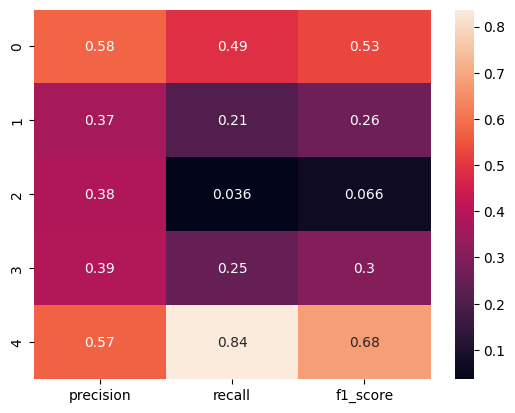

In [53]:
sns.heatmap(merrics1, annot=True)

<Axes: >

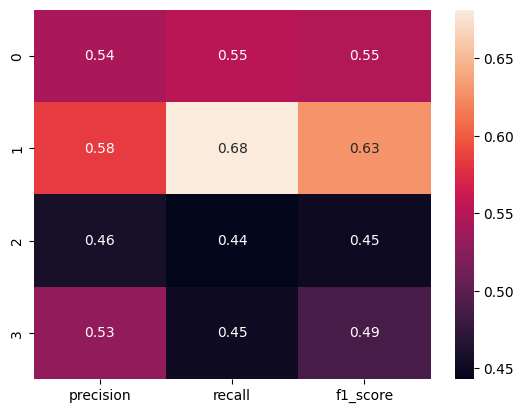

In [54]:
sns.heatmap(merrics2, annot=True)

In [69]:
pred2_1 = pd.DataFrame(model2.predict(X1_val), index=X1_val.index)

In [70]:
pred = pred1.copy()
pred.columns = ['pred1']

y1_val.name = 'gt1'
pred2_1.columns = ['pred2_1']
y2_val.name = 'gt2'

pred = pred.join(y1_val)
pred = pred.join(pred2_1)
pred = pred.join(y2_val)

In [74]:
pred[['pred2_1', 'gt2']]

,pred2_1,gt2
14671,6,7.0
3741,7,5.0
20916,4,NaN
17544,7,NaN
17845,4,NaN
...,...,...
25261,5,NaN
17498,6,7.0
19655,4,6.0
16880,5,NaN


In [92]:
def new_pred_gt(X):
    pred1 = X['pred1']
    gt1 = X['gt1']
    pred2_1 = X['pred2_1']
    gt2 = X['gt2']
    
    
    if gt1 == 4 and pred1 == 4:
        return [pred2_1, gt2]
    elif gt1 != 4 and pred1 == 4:
        return [pred2_1, gt1]
    elif gt1 == 4 and pred1 != 4:
        return [pred1, gt2]
    elif gt1 != 4 and pred1 != 4:
        return [pred1, gt1]
    assert False


In [93]:
pred[['pred', 'gt']] = pred.apply(new_pred_gt, axis=1, result_type='expand')

In [100]:
precision, recall, f1_score, support = precision_recall_fscore_support(pred['gt'], pred['pred'])
merrics = create_table(precision, recall, f1_score)

<Axes: >

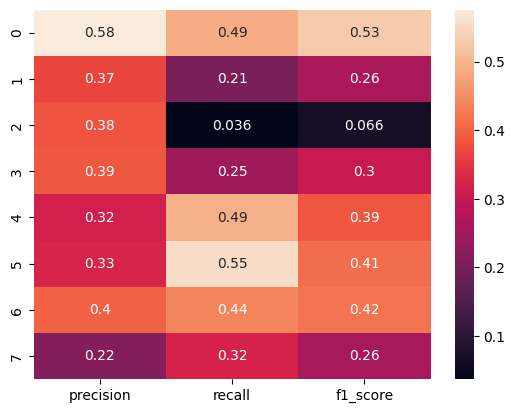

In [101]:
sns.heatmap(merrics, annot=True)

<Axes: >

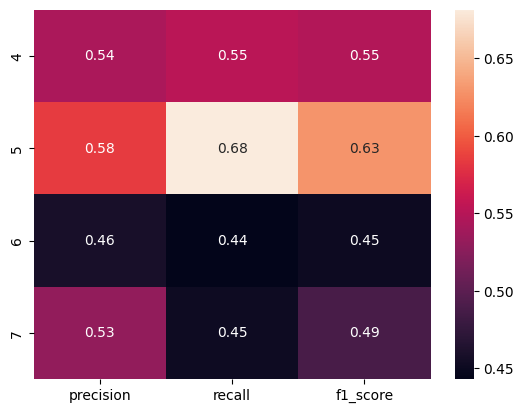

In [102]:
merrics2.index = [4, 5, 6, 7]
sns.heatmap(merrics2, annot=True)

<Axes: >

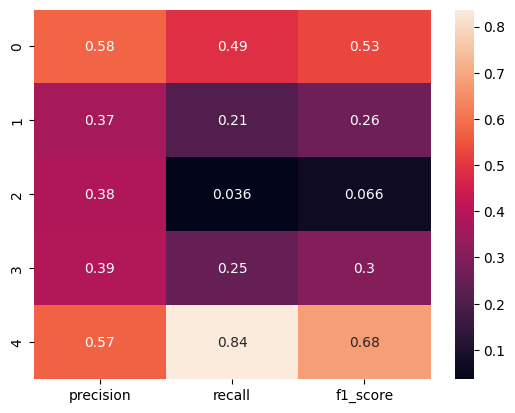

In [103]:
sns.heatmap(merrics1, annot=True)